# Lecture 9: Density Estimation

# 9.1. Outlier Detection Using Probabilistic Models

After the introduction of unsupervised learning from last lecture, we will now look at a specific problem which unsupervised learning can be used to solve, density estimation.

Density estimation is the problem of estimating a probability distribution from data. Let's first look at a motivating practical problem that involves performing density estimation: outlier detection.

## 9.1.1. Review: Unsupervised Learning

We have a dataset *without* labels. Our goal is to learn something interesting about the structure of the data:

* Clusters hidden in the dataset.

* Useful signal hidden in noise, e.g. human speech over a noisy phone.

* Outliers: particularly unusual and/or interesting datapoints.

## 9.1.2. Outlier Detection

Let's us first formulate the problem of outlier detection. 

Suppose we have a (unsupervised) dataset $\mathcal{D} = \{x^{(i)} \mid i = 1,2,...,n\}$. For example, each $x^{(i)}$  could represent:

* A summary of traffic logs on a computer network

* The state of a machine in a factory

The goal of outlier detection is, given a new input $x'$, we want to determine whether $x'$ is "normal" or not. The notion of "normal" is elaborated in the below section.

### 9.1.2.1. Data Distribution and Outliers

Formally, we assume that the dataset $\mathcal{D}$ is sampled IID from the *data distribution* $P_\text{data}$. We denote this as
$$x \sim P_\text{data}.$$

Outlier detection can be thought of as answering the question:

$$ \text{Does the new point $x'$ originate from $P_\text{data}$?} $$

## 9.1.3. Density Estimation

So how can we detect outliers? We can use density estimation to help us do that!

Definition: An unsupervised probabilistic model is a probability distribution that maps datapoints to probabilities:
$$P_\theta(x) : \mathcal{X} \to [0,1].$$
Probabilistic models often have *parameters* $\theta \in \Theta$. 

(For 9.1, we will assume our interested probabilistic models do have a set of finite parameters $\theta$ that nicely describe the behavior of the probabilistic model, i.e., they are "parametric". This means choosing a good model is a matter of choosing a good $\theta$)

The task of __density estimation__ is to learn a probablisitc model $P_\theta$ on an unsupervised dataset $\mathcal{D}$ to approximate the true data distribution $P_\text{data}$.

### 9.1.3.1. Outlier Detection Using Density Estimation

Recall that in outlier detection, whether an input is "normal" translates to whether the input originate from the data distribution $P_\text{data}$. We need to somewhat know $P_\text{data}$ in order to say if an input is an outlier.

Density estimation is precisely the task of estimating $P_\text{data}$ with $P_\theta$.

Thus, we can perform outlier detection with probabilistic models:

1. __Density estimation__: We fit $P_\theta$ on $\mathcal{D}$ to approximate $P_\text{data}$

2. __Outlier detection__: Given $x'$, we use $P_\theta(x')$ to determine if $x'$ is an outlier.

### 9.1.3.2. Why Use Probabilistic Models?

There are many other tasks that we can solve with a good model $P_\theta$.

1. Generation: sample new objects from $P_\theta$, such as images.

2. Structure learning: find interesting structure in $P_\text{data}$

3. Density estimation: approximate $P_\theta \approx P_\text{data}$ and use it to solve any downstream task (generation, clustering, outlier detection, etc.).

We are going to be interested in the latter.

### 9.1.3.3. Maximum Likelihood Estimation

So how exactly can one learn a probabilistic model $P_\theta(x)$, i.e., learn good/optimal $\theta$, that estimates the data distribution $P_\text{data}$? 

One way we can do that is by optimizing
the *maximum log-likelihood* objective
$$
\max_\theta \ell(\theta) = \max_{\theta} \frac{1}{n}\sum_{i=1}^n \log P_\theta({x}^{(i)}).
$$

This asks that $P_\theta$ assign a high probability to the training instances in the dataset $\mathcal{D}$.

Maximizing likelihood is closely related to minimizing the Kullback-Leibler (KL) divergence $D(\cdot\|\cdot)$ between the model distribution and the data distribution.
$$
D(P_\text{data} \| P_\theta) = \sum_{{\bf x}} P_\text{data}({\bf x}) \log \frac{P_\text{data}({\bf x})}{P_\theta({\bf x})}.
$$

The KL divergence is always non-negative, and equals zero when $P_\text{data}$ and $P_\theta$ are identical. This makes it a natural measure of similarity that's useful for comparing distributions. 

### 9.1.3.4. Toy Example: Flipping a Random Coin

How should we choose $P_\theta(x)$, i.e., choose $\theta$, if 3 out of 5 coin tosses are heads? Let's apply maximum likelihood learning.

* Our model is $P_\theta(x=H)=\theta$ and $P_\theta(x=T)=1-\theta$

* Our data is: $\{H,H,T,H,T\}$ 

* The likelihood of the data is $\prod_{i} P_\theta(x_i)=\theta \cdot \theta \cdot (1-\theta) \cdot \theta \cdot (1-\theta)$.

We optimize for $\theta$ which makes the data most likely. What is the solution in this case?

Below we plot the likelihood of the observed data (3 heads out of 5 coin tosses) vs $\theta$:

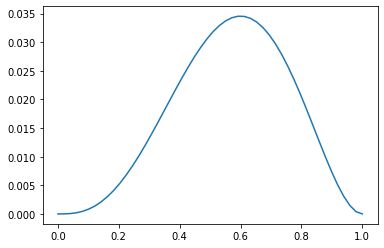

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# our dataset is {H, H, T, H, T}; if theta = P(x=H), we get:
coin_likelihood = lambda theta: theta*theta*(1-theta)*theta*(1-theta)

theta_vals = np.linspace(0,1)
# plot the likedlihood at each theta
plt.plot(theta_vals, coin_likelihood(theta_vals))

You can see that the optimizing $\theta$ is $0.6$.

Given a trained model $P_\theta$ with $\theta = 0.6$, we can ask for the probability of seeing a sequence of ten tails:

$$P(\text{ten tails}) =  \prod_{j=1}^{10} P_\theta(x^{(j)}=T) = (1-0.6)^{10} \approx 10^{-4}$$

This gives us an estimate of whether certain sequences are likely or not. If they are not, then they are outliers!

# 9.2. Kernel Density Estimation

Next, we will look at a more sophisticated technique for estimating densities.

## 9.2.1. Review: Density Estimation

Recall that the problem of density estimation is to approximate the data distribution $P_\text{data}$ with the model $P$.
$$ P \approx P_\text{data}. $$

(Notice that the probabilistic model $P$ needs not be nicely characterized by a set of parameters $\theta$. They can be "non-parametric")

It's also a general learning task. We can solve many downstream tasks using a good model $P$:

* Outlier and novelty detection

* Generating new samples $x$

* Visualizing and understanding the structure of $P_\text{data}$

## 9.2.2. Histogram Density Estimation

Perhaps, one of the simplest approaches to density estimation (constructing an estimating probabilistic model) is by forming a histogram. This definitely seems conceptually simpler than maximizing the likelihood of data with respect to a parameterized probabilistic model from earlier.

To construct a histogram, we partition the input space $x$ into a $d$-dimensional grid and counts the number of points in each cell/bin.

### 9.2.2.1. Histogram Density Estimation: Example

This is best illustrated by an example. 

Let's start by creating a simple 1D dataset coming from a mixture of two Gaussians:

$$P_\text{data}(x) = 0.3 \cdot \mathcal{N}(x ; \mu=0, \sigma=1) + 0.7 \cdot \mathcal{N}(x ; \mu=5, \sigma=1)$$

In [23]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html
import numpy as np
np.random.seed(1)

N = 20 # number of points
# concat samples from two Gaussians:
X = np.concatenate((
    np.random.normal(0, 1, int(0.3 * N)), 
    np.random.normal(5, 1, int(0.7 * N))
))[:, np.newaxis]

# print out X
print(X.flatten())

[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  6.74481176  4.2387931   5.3190391   4.75062962  6.46210794  2.93985929
  4.6775828   4.61594565  6.13376944  3.90010873  4.82757179  4.12214158
  5.04221375  5.58281521]


We can now estimate the density using a histogram, counting the number of datapoints in each bin. 

Below, we visualize the result histogram:

(-0.02, 0.25)

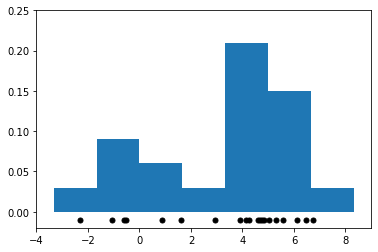

In [41]:
import matplotlib.pyplot as plt

# We set the number of bins to be equal to 10 - 1 = 9 (np.linspace gets us boundaries of the bins)
# Though the figure seems like it has less than 9 bins because some bins do not have any data
bins = np.linspace(-5, 10, 10)
plt.hist(X[:, 0], bins=bins, density=True) # plot the histogram
plt.plot(X[:, 0], np.full(X.shape[0], -0.01), '.k', markersize=10) # plot the points in X
plt.xlim(-4, 9)
plt.ylim(-0.02, 0.25)

### 9.2.2.2. Limitations of Histograms

Though conceptually simple, histogram-based methods have a number of shortcomings:

* The histogram is not "smooth". We usually expect elements in the same local region of the data distribution to have somewhat similar probabilities (no sudden change).

* The shape of the histogram depends on the bin positions.

* The number of grid cells increases exponentially with dimension $d$.

Let's visualize what we mean when we say that shape of the histogram depends on the histogram bins. Below we plot two figures, where the bins of the right figure are the bins of the left figure but shifted by 0.75:

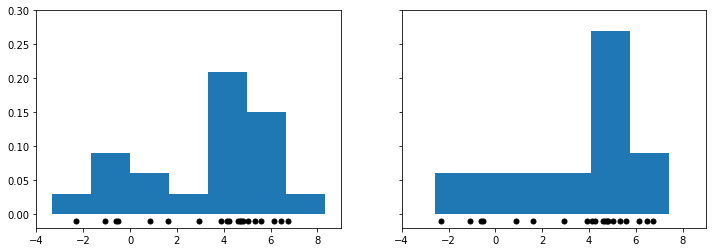

In [38]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,4))
ax[0].hist(X[:, 0], bins=bins, density=True) # plot the histogram
ax[1].hist(X[:, 0], bins=bins+0.75, density=True) # plot the histogram with bin centers shifted by 0.75
for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), '.k', markersize=10) # plot the points in X
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.3)

As you can see, the two figures look very different even by just a small shift of bins.

## 9.2.3. Kernel Density Estimation
Kernel density estimation (KDE) is a different approach to density estimation that address some of the issues of histogram density estimation.

* In histogram density estimation, the density is proportional to:

$$ P_\theta(x) \propto \text{\# of points in the bin where $x$ falls} $$

* In kernel density estimation, the density is proportional to:

$$ P_\theta(x) \propto \text{\# of points in $\mathcal{D}$ "near" $x$} $$

Here, $\propto$ means "proportional to" (up to a normalizing constant).

In other words:

* If $x$ is in an area with many points in $\mathcal{D}$, then $P_\theta(x)$ is large

* If $x$ is in an area with few points in $\mathcal{D}$, then $P_\theta(x)$ is small

You can also view KDE as counting the % of points that fall in a "bin" centered at $x$.

### 9.2.3.1 Tophat Kernel Density Estimation

The simplest form of this strategy (Tophat KDE) assumes a model of the form
$$P_\delta(x) = \frac{N(x; \delta)}{n},$$
where
$$ N(x; \delta) = |\{x^{(i)} : ||x^{(i)} - x || \leq \delta/2\}|, $$
is the number of points that are within a bin of with $\delta$ centered at $x$.

This is best understood via a picture. Below we fit Tophat KDE on the 1D mixture of two Gaussians dataset from 9.2.2.1. and visualize it.

(-0.02, 0.32)

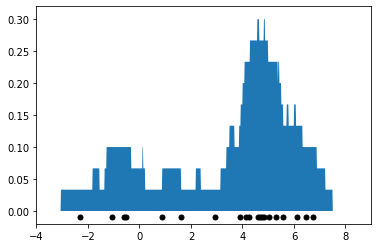

In [47]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(X) # fit a KDE model
x_ticks = np.linspace(-5, 10, 1000)[:, np.newaxis] # choose 1000 points on x-axis
log_density = kde.score_samples(x_ticks) # compute density at 1000 points

plt.fill(x_ticks[:, 0], np.exp(log_density)) # plot the density estimate
plt.plot(X[:, 0], np.full(X.shape[0], -0.01), '.k', markersize=10) # plot the points in X as black dots
plt.xlim(-4, 9)
plt.ylim(-0.02, 0.32)

The above algorithm no longer depends on the position of bins like histogram density estimation.

However, it still has the problem of producing a density estimate that is not smooth.

We are going to resolve this by replacing histogram counts with weighted averages:
\begin{align*}
P_\theta(x) 
& \propto \text{\# of points in $\mathcal{D}$ "near" $x$, weighted by distance from $x$} \\
& = \sum_{i=1}^n \text{weight}(x^{(i)}, x).
\end{align*}

We count all points $x^{(i)}$, but each gets a $\text{weight}(x^{(i)}, x)$ that is large if $x^{(i)}$ and $x$ are "similar". We will talk about this "similarity" in the following section.

### 9.2.3.2. Kernels and Kernel Density Estimation

A *kernel function* $K : \mathcal{X} \times \mathcal{X} \to [0, \infty]$ maps pairs of vectors $x, z \in \mathcal{X}$ to a real-valued score $K(x,z)$.

* A kernel represents the similarity between $x$ and $z$.

* We will see many ways of defining "similarity"; they will all fit the framework that follows.

A kernelized density model $P$ takes the form:
$$P(x) \propto \sum_{i=1}^n K(x, x^{(i)}).$$
This can be interpreted in several ways:

* We count the number of points "near" $x$, but each $x^{(i)}$ has a weight $K(x, x^{(i)})$ that depends on similarity between $x, x^{(i)}$.

* We place a "micro-density" $K(x, x^{(i)})$ at each $x^{(i)}$; the final density $P(x)$ is their sum.

### 9.2.3.3. Types of Kernels

Here, we introduce a few kernels that are popular for density estimation.

The following kernels are available in `scikit-learn`.

* Gaussian kernel $K(x,z; \delta) \propto \exp(-||x-z||^2/2\delta^2)$

* Tophat kernel $K(x,z; \delta) = 1 \text{ if } ||x-z|| \leq \delta/2$ else $0$.

* Epanechnikov kernel $K(x,z; \delta) \propto 1 - ||x-z||^2/\delta^2$

* Exponential kernel $K(x,z; \delta) \propto \exp(-||x-z||/\delta)$

* Linear kernel $K(x,z; \delta) \propto (1 - ||x-z||/\delta)^+$

It's easier to understand these kernels by looking at the corresponding visual figures plotted below:

Text(0.5, 1.0, 'Available Kernels')

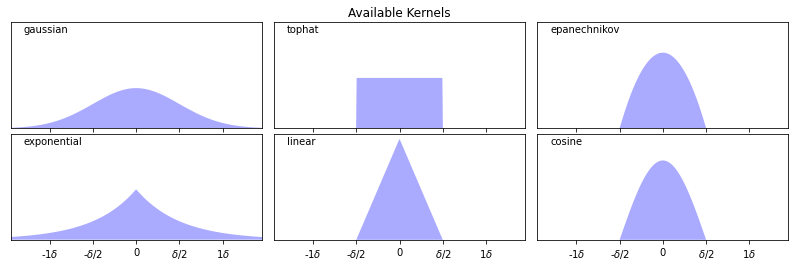

In [81]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html
X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,4))
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)

def format_func(x, loc):
    if x == 0:
        return '0'
    elif x == 1:
        return '$\delta/2$'
    elif x == -1:
        return '-$\delta/2$'
    else:
        return '%i$\delta$' % (int(x/2))

for i, kernel in enumerate(['gaussian', 'tophat', 'epanechnikov',
                            'exponential', 'linear', 'cosine']):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), '-k', fc='#AAAAFF')
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title('Available Kernels')


### 9.2.3.4. Kernel Density Estimation: Example

Let's look at an example in the context of the 1D points (mixture of two Gaussians) we have seen earlier.

We will fit a model of the form
$$P(x) = \sum_{i=1}^n K(x, x^{(i)})$$
with a Gaussian kernel $K(x,z; \delta) \propto \exp(-||x-z||^2/2\delta^2)$.

Below we plot the density estimate as blue line, the datapoints as black dots, and example kernels as red dotted line.

(-0.02, 0.32)

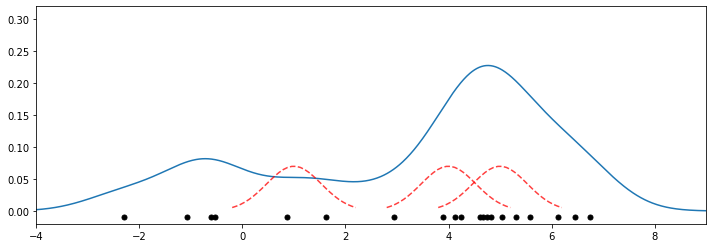

In [77]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X) # fit a KDE model
x_ticks = np.linspace(-5, 10, 1000)[:, np.newaxis] # choose 1000 points on x-axis
log_density = kde.score_samples(x_ticks) # compute density at 1000 points
gaussian_kernel = lambda z : lambda x: np.exp(-np.abs(x-z)**2/(0.75**2)) # gaussian kernel
kernel_linspace = lambda x : np.linspace(x-1.2,x+1.2,30)

plt.figure(figsize=(12,4))
plt.plot(x_ticks[:, 0], np.exp(log_density)) # plot the density estimate
plt.plot(X[:, 0], np.full(X.shape[0], -0.01), '.k', markersize=10) # plot the points in X as black dots
plt.plot(kernel_linspace(4), 0.07*gaussian_kernel(4)(kernel_linspace(4)), '--', color='r', alpha=0.75)
plt.plot(kernel_linspace(5), 0.07*gaussian_kernel(5)(kernel_linspace(5)), '--', color='r', alpha=0.75)
plt.plot(kernel_linspace(1), 0.07*gaussian_kernel(1)(kernel_linspace(1)), '--', color='r', alpha=0.75)
plt.xlim(-4, 9)
plt.ylim(-0.02, 0.32)

Recall that the dataset is a mixture of two Gaussians centered at $x = 0$ and $x = 5$. This estimate does look consistent with that.

### 9.2.3.5. KDE in Higher Dimensions

In principle, kernel density estimation also works in higher dimensions.

However, the number of datapoints needed for a good fit incrases exponentially with the dimension, which limits the applications of this model in high dimensions.

### 9.2.3.6. Choosing Hyperparameters for Kernels

Each kernel has a notion of "bandwidth" $\delta$. This is a hyperparameter that controls the "smoothness" of the fit.

* We can choose it using inspection or heuristics like we did for $K$ in $K$-Means.

* Because we have a probabilistic model, we can also estimate likelihood on a holdout dataset (more on this later!)

Let's illustrate how the bandwidth affects smoothness via an example.

Below we plot two figures, left with very high bandwidth and right with very low bandwidth. 

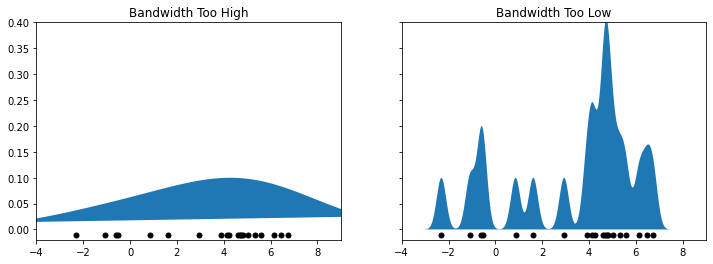

In [91]:
from sklearn.neighbors import KernelDensity

kde1 = KernelDensity(kernel='gaussian', bandwidth=3).fit(X) # fit a KDE model
kde2 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X) # fit a KDE model

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,4))
ax[0].fill(x_ticks[:, 0], np.exp(kde1.score_samples(x_ticks))) # plot the density estimate
ax[1].fill(x_ticks[:, 0], np.exp(kde2.score_samples(x_ticks))) # plot the density estimate
ax[0].set_title('Bandwidth Too High')
ax[1].set_title('Bandwidth Too Low')

for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), '.k', markersize=10) # plot the points in X
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.4)

You can see that the left figure is too smoothed out, making us lose a lot of information. On the other hand, the right figure is very sharp, making it less generalizable.

### 9.2.3.7. Algorithm: Kernel Density Estimation

We summarize the kernel density estimation algorithm below:

* __Type__: Unsupervised learning (density estimation).

* __Model family__: Non-parametric. Sum of $n$ kernels.

* __Objective function__: Log-likelihood to choose optimal bandwidth.

* __Optimizer__: Grid search.

### 9.2.3.8. Pros and Cons of KDE

We have introduced kernel density estimation which overcomes some of the drawbacks of histogram density estimation introduced earlier. We summarize the pros and cons of KDE below:

Pros:

* Can approximate any data distribution arbitrarily well.

Cons:

* Need to store entire dataset to make queries, which is computationally prohibitive.

* Number of data needed scale exponentially with dimension ("curse of dimensionality").

# 9.3. Nearest Neighbors

We are now going to take a little detour back to supervised learning and apply some of these density estimation ideas to supervised learning.

Precisely, we will look at an algorithm called Nearest Neighbors.

## 9.3.1. Review: Classification

Consider a supervised training dataset $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$.

We distinguish between two types of supervised learning problems depending on the targets $y^{(i)}$. 

1. __Regression__: The target variable $y \in \mathcal{Y}$ is continuous:  $\mathcal{Y} \subseteq \mathbb{R}$.

2. __Classification__: The target variable $y$ is discrete and takes on one of $K$ possible values:  $\mathcal{Y} = \{y_1, y_2, \ldots y_K\}$. Each discrete value corresponds to a *class* that we want to predict.

## 9.3.2. A Simple Classification Algorithm: Nearest Neighbors

Suppose we are given a training dataset $\mathcal{D} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(n)}, y^{(n)})\}$. At inference time, we receive a query point $x'$ and we want to predict its label $y'$.

A really simple but surprisingly effective way of returning $y'$ is the *nearest neighbors* approach.

* Given a query datapoint $x'$, find the training example $(x, y)$ in $\mathcal{D}$ that's closest to $x'$, in the sense that $x$ is "nearest" to $x'$

* Return $y$, the label of the "nearest neighbor" $x$.

In the example below on the Iris dataset, the red cross denotes the query $x'$. The closest class to it is "Virginica". (We're only using the first two features in the dataset for simplicity.)

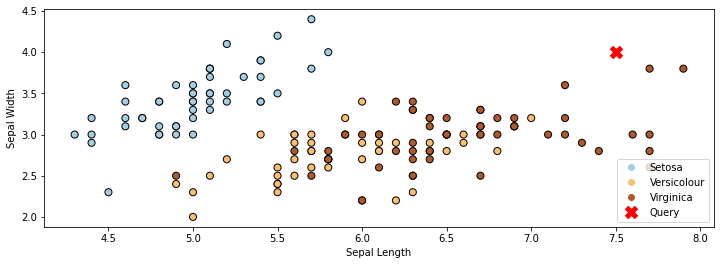

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 4]

# Plot also the training points
p1 = plt.scatter(iris_X.iloc[:, 0], iris_X.iloc[:, 1], c=iris_y,
            edgecolor='k', s=50, cmap=plt.cm.Paired)
p2 = plt.plot([7.5], [4], 'rx', ms=10, mew=5)
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.legend(['Query Point', 'Training Data'], loc='lower right')
plt.legend(handles=p1.legend_elements()[0]+p2, labels=['Setosa', 'Versicolour', 'Virginica', 'Query'], loc='lower right')

## 9.3.3. Choosing a Distance Function

How do we select the point $x$ that is the closest to the query point $x'$? There are many options:

* The Euclidean distance $|| x - x' ||_2 = \sqrt{\sum_{j=1}^d |x_j - x'_j|^2)}$ is a popular choice.

* The Minkowski distance $|| x - x' ||_p = (\sum_{j=1}^d |x_j - x'_j|^p)^{1/p}$ generalizes the Euclidean, L1 and other distances.

* The Mahalanobis distance $\sqrt{x^\top V x}$ for a positive semidefinite matrix $V \in \mathbb{R}^{d \times d}$ also generalizes the Euclidean distnace.

* Discrete-valued inputs can be examined via the Hamming distance $|\{j : x_j \neq x_j'\}|$ and other distances.

Let's apply Nearest Neighbors to the above dataset using the Euclidean distance (or equiavalently, Minkowski with $p=2$)

Below we color each position in the grid with the corresponding class color (according to Nearest Neighbors with Euclidean distance)

Text(0, 0.5, 'Sepal Width')

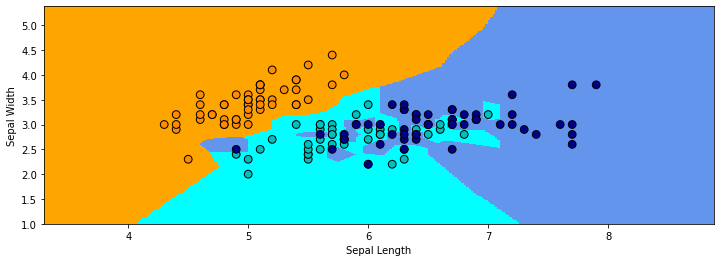

In [23]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
from sklearn import neighbors
from matplotlib.colors import ListedColormap

# Train a Nearest Neighbors Model
clf = neighbors.KNeighborsClassifier(n_neighbors=1, metric='minkowski', p=2)
clf.fit(iris_X.iloc[:,:2], iris_y)

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = iris_X.iloc[:, 0].min() - 1, iris_X.iloc[:, 0].max() + 1
y_min, y_max = iris_X.iloc[:, 1].min() - 1, iris_X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(iris_X.iloc[:, 0], iris_X.iloc[:, 1], c=iris_y, cmap=cmap_bold,
            edgecolor='k', s=60)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')

In the above example, the regions of the 2D space that are assigned to each class are highly irregular. In areas where the two classes overlap, the decision of the boundary flips between the classes, depending on which point is closest to it.

## 9.3.4. K-Nearest Neighbors

Intuitively, we expect the true decision boundary to be smooth. Therefore, we average $K$ nearest neighbors at a query point.

* Given a query datapoint $x'$, find the $K$ training examples $\mathcal{N} = \{(x^{(1)}, y^{(1)}), (x^{(2)}, y^{(2)}), \ldots, (x^{(K)}, y^{(K)})\} \subseteq D$ that are closest to $x'$.

* Return $y_\mathcal{N}$, the consensus label of the neighborhood $\mathcal{N}$.

The consesus $y_\mathcal{N}$ can be determined by voting, weighted average, kernels, etc.

Let's look at Nearest Neighbors with a neighborhood of 30. Once again, we color each position in the grid with the corresponding class color. The decision boundary is much smoother than before.

Text(0, 0.5, 'Sepal Width')

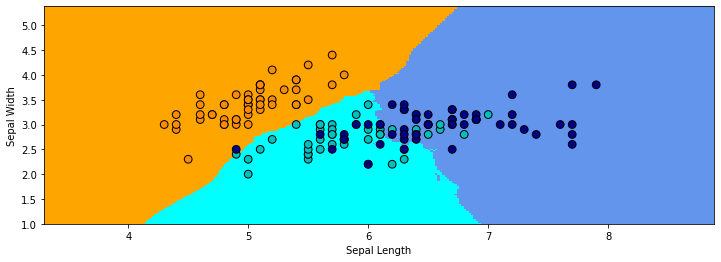

In [8]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# Train a Nearest Neighbors Model
clf = neighbors.KNeighborsClassifier(n_neighbors=30, metric='minkowski', p=2)
clf.fit(iris_X.iloc[:,:2], iris_y)
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
plt.scatter(iris_X.iloc[:, 0], iris_X.iloc[:, 1], c=iris_y, cmap=cmap_bold,
            edgecolor='k', s=60)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')

### 9.3.4.1. KNN Estimates Data Distribution

Suppose that the output $y'$ of KNN is the average target in the neighborhood $\mathcal{N}(x')$ around the query $x'$.
Observe that we can write:
$$y' = \frac{1}{K} \sum_{(x, y) \in \mathcal{N}(x')} y \approx \mathbb{E}[y \mid x'].$$

* When $x \approx x'$ and when $\mathbb{P}$ is reasonably smooth, each $y$ for $(x,y) \in \mathcal{N}(x')$ is approximately a sample from $\mathbb{P}(y\mid x')$ (since $\mathbb{P}$ doesn't change much around $x'$, $\mathbb{P}(y\mid x') \approx \mathbb{P}(y\mid x)$).

* Thus $y'$ is essentially a Monte Carlo estimate of $\mathbb{E}[y \mid x']$ (the average of $K$ samples from $\mathbb{P}(y\mid x')$).

### 9.3.4.2. Algorithm: K-Nearest Neighbors

We summarize the K-Nearest Neighbors algorithm below:

* __Type__: Supervised learning (regression and classification)

* __Model family__: Consensus over $K$ training instances.

* __Objective function__: Euclidean, Minkowski, Hamming, etc.

* __Optimizer__: Non at training. Nearest neighbor search at inference using specialized search algorithms (Hashing, KD-trees).

* __Probabilistic interpretation__: Directly approximating the density $P_\text{data}(y|x)$.

### 9.3.4.3 Non-Parametric Models

Nearest neighbors is an example of a *non-parametric* model. Parametric vs. non-parametric are is a key distinguishing characteristic for machine learning models.

A parametric model $f_\theta(x) : \mathcal{X} \times \Theta \to \mathcal{Y}$ is defined by a finite set of parameters $\theta \in \Theta$ whose dimensionality is constant with respect to the dataset. Linear models of the form
$$ f_\theta(x) = \theta^\top x $$
are an example of a parametric model.

On the other hand, for a non-parametric model, the function $f$ uses the entire training dataset (or a post-proccessed version of it) to make predictions, as in $K$-Nearest Neighbors. In other words, the complexity of the model increases with dataset size. Because of this, non-parametric models have the advantage of not losing any information at training time. Nevertheless, they are also computationally less tractable and may easily overfit the training set.

### 9.3.4.4. Pros and Cons of KNN

We have introduced KNN, our first non-parametric model for supervised learning. We summarize the pros and cons of the algorithm below:

Pros:

* Can approximate any data distribution arbtrarily well.

Cons:

* Need to store entire dataset to make queries, which is computationally prohibitive.

* Number of data needed scale exponentially with dimension ("curse of dimensionality").